In [1]:
import pandas as pd

In [2]:
import multiprocessing as mp
from sklearn import preprocessing

In [3]:
citation_df = pd.read_csv('http://s3.amazonaws.com/data.patentsview.org/20181127/download/uspatentcitation.tsv.zip', sep='\t')

In [4]:
citation_df.head()

,uuid,patent_id,citation_id,date,name,kind,country,category,sequence
0,00000jd7thmiucpaol1hm1835,5354551,4875247,1989-10-01,Berg,NaN,US,NaN,11
1,00000l0ooxrvfv6jkenobhwis,D674253,D519335,2006-04-01,Ishii,S,US,cited by examiner,13
2,00000nv59m7vgyvfxehud4477,D809697,1963218,1934-06-01,Wakefield,A,US,cited by examiner,0
3,00001jxaxme3a89hidjtdkoi4,D808172,7207426,2007-04-01,Godshaw et al.,B2,US,cited by applicant,14
4,00001nlwuimui60vu3k1yzjqd,8683318,6642945,2003-11-01,Sharpe,B1,US,cited by examiner,6


In [6]:
df = pd.read_json('cs_cpc_training_500.json')

In [7]:
df.head()

,publication_number,grant_date,cpc
0,9022049,20150505,"[A45, A45B, A]"
1,9025696,20150505,"[H04L27/26, H04L, H04B7/06, H04B7/0413, H04B7/..."
10,9033154,20150519,"[A61B90/00, A, B, A61, B65D, B65, A61B, A61B50..."
100,9036956,20150519,"[G02B6/0081, G02B6/24, G02B6/10, G02B6/42, G02..."
1000,9034866,20150519,"[C07D513/00, C07D487/00, C, C07D, C07D519/00, ..."


In [8]:
df_CPC_G = df[df['cpc'].str.contains("G", regex=False)]

In [9]:
df_CPC_G['pub_date'] = pd.to_datetime(df_CPC_G['grant_date'], format='%Y%m%d')

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [10]:
df_CPC_G = df_CPC_G.loc[df_CPC_G['pub_date'] > '2015-01-01']

In [15]:
df_CPC_G['GrantYearMonth'] = pd.to_datetime(df_CPC_G['pub_date']).dt.to_period('M')

In [133]:
def extract_section_to_sc(dataframe):
    sect = []
    for i in range(dataframe.shape[0]):
        st = dataframe.iloc[i,2]
        f = []
        for x in st:
            g = x[0:4]
            f.append(g)
        f = list(set(f))
        sect.append(f)
    return sect

In [134]:
df_CPC_G['short_cpc'] = extract_section_to_sc(df_CPC_G)

In [135]:
mlb = preprocessing.MultiLabelBinarizer()
cpc_ohe_df = pd.DataFrame(mlb.fit_transform(df_CPC_G['short_cpc']),columns=mlb.classes_, index=df_CPC_G.index)

In [136]:
df1 = pd.concat([df_CPC_G, cpc_ohe_df], axis = 1)

In [137]:
df1 = df1.drop(['cpc', 'pub_date', 'publication_number', 'grant_date', 'short_cpc'], axis=1)

In [138]:
df1.head()

,GrantYearMonth,A,A01,A01B,A01C,A01D,A01F,A01G,A01H,A01J,...,H04N,H04Q,H04R,H04S,H04W,H05,H05B,H05G,H05H,H05K
100,2015-05,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000001,2016-04,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1000002,2016-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000005,2016-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000010,2016-04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
import math

In [129]:
def test_idf(series):
    idf = math.log10(len(series)/(1 + series.sum()))
    return(idf)

In [108]:
dfgroup = df1.groupby(['GrantYearMonth']).agg(test_idf)

In [139]:
test = ['G06Q', 'G06N']

In [140]:
df2 = pd.DataFrame(dfgroup.to_records())

In [141]:
test_df = df2[test]

In [142]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [143]:
X = np.arange(len(df2))
Y = test_df.sum(axis=1)/df2.iloc[:,1:].sum(axis=1)

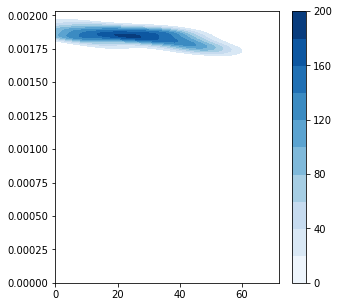

In [146]:
fig, ax = plt.subplots(figsize=(5,5))
sns.kdeplot(X, Y, cmap="Blues", shade=True, shade_lowest=False, ax=ax, cbar = True)
ax.set_xlim(0, None)
ax.set_ylim(0, None)
plt.show()

In [ ]:
test2 = []